In [1]:
# Parameters
# Refer to injected parameters for any run.ipynb (similar cell below)
strain = "BY4741"
locus = "FKS1-HS1"
compound = "caspofungin"

In [2]:
# Parameters
strain = "BY4741"
locus = "FKS1-HS2"
compound = "caspofungin"


# Notebook to plot heatmaps from selection coefficients

## Import libraries

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams["svg.fonttype"] = "none"

## Specify paths and constants

In [4]:
### Input
data_path = f"../classified/{strain}_{locus}/refined_classification.csv"
thresh = f"../classified/{strain}_{locus}/thresholds.csv"

### Output

### Constants
AA_LIST = "*PGCQNTSEDKHRWYFMLIVA"
AA_SORT = dict(zip(list(AA_LIST), list(range(0, len(AA_LIST)))))

### Color map
cmap = sns.color_palette(
    "blend:#009B9E,#42B7B9,#A7D3D4,#F1F1F1,#E4C1D9,#D691C1,#C75DAB",  # CARTOColors Tropic
    as_cmap=True,
)
cmap.set_bad(".5")

### Classification thresholds
if compound == "none":
    thresh = -0.7
    cax_label = "del"
else:
    thresh_df = pd.read_csv(thresh, index_col=0)
    thresh = thresh_df.loc[
        (thresh_df.compound == compound) & (thresh_df.thresh == "low"), "val"
    ].item()
    cax_label = "res"

## Import data

In [5]:
all_conditions = pd.read_csv(data_path)
df = all_conditions[all_conditions.compound == compound]

## Get single mutants

In [6]:
singles = df[df.aa_pos != "not-applicable"][["aa_pos", "alt_aa", "s", "sensres"]].copy()
singles["aa_pos"] = singles["aa_pos"].astype(int)

## Handle WT

### Retrieve coordinates and selection coefficient

In [7]:
wtaa = df.loc[df.aa_pos == "not-applicable", "aa_seq"].values[0]
wtcoord = [(i + 0.5, list(AA_LIST).index(v) + 0.5) for i, v in enumerate(wtaa)]
wt_fitness = df.loc[df.aa_pos == "not-applicable", "s"].values[0]
wt_class = df.loc[df.aa_pos == "not-applicable", "sensres"].values[0]

### Duplicate WT for each position

In [8]:
# Assume the first position is in the input dataframe
pos_offset = singles.aa_pos.min()

wtdf = pd.DataFrame(
    [(int(i) + pos_offset, aa, wt_fitness, wt_class) for i, aa in enumerate(wtaa)],
    columns=["aa_pos", "alt_aa", "s", "sensres"],
)

## Assemble and save for downstream processing

In [9]:
filtered = pd.concat([wtdf, singles], ignore_index=True)
filtered.to_csv(f"../heatmap_data/{strain}_{locus}_{compound}.csv", index=False)

## Pivot and sort dataframe

In [10]:
wide = filtered.pivot(index="alt_aa", columns="aa_pos", values="s")
wide.sort_index(key=lambda x: x.map(AA_SORT), inplace=True)

## Plot heatmap

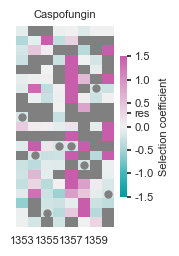

In [11]:
# Prepare graph space
sns.set_theme(
    rc={
        "figure.figsize": (1.8, 2.6),
        "font.size": 8,
        "legend.title_fontsize": 8,
        "legend.fontsize": 8,
        "axes.labelsize": 8,
        "axes.titlesize": 8,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
    },
    style="whitegrid",
)
f, ax = plt.subplots()

# Mask for missing values
mask = pd.isnull(wide)

# Draw heatmap
ax = sns.heatmap(
    wide,
    mask=mask,
    cmap=cmap,
    vmin=-1.5,
    center=0,
    vmax=1.5,
    xticklabels=2,
    yticklabels=False,
    cbar_kws={"label": "Selection coefficient", "shrink": 0.7},
)

ax.set_title(compound.title())
ax.set(xlabel=None, ylabel=None)
ax.tick_params(axis="x", length=3)
plt.yticks(rotation=0)

cax = ax.figure.axes[-1]
cax.set_yticks(
    [x for x in cax.get_yticks()] + [thresh],
    labels=[x for x in cax.get_yticks()] + [cax_label],
)
cax.tick_params(length=3, pad=2)

# Display WT sequence
for o in wtcoord:
    ax.plot(o[0], o[1], marker="o", color=".5", markersize=5)

plt.tight_layout()